In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!ls drive/"My Drive"/miniDset
!mkdir result
!mkdir result/figures

Rendered_Imgs  Voxel


In [ ]:
from torch.utils.data import Dataset as dset
# from torch.utils.data import DataLoader
import os
import numpy as np
from scipy.io import loadmat
from PIL import Image
# from torchvision.transforms import ToTensor
def generate_sample_list(VoxelFolderPath):
    """
    Return a list containing all subpathes, like 02818832_bed/10c15151ebe3d237240ea0cdca7b391a
    """
    categories = sorted(os.listdir(VoxelFolderPath))
    samples = []
    for category in categories:
        ids = sorted(os.listdir(os.path.join(VoxelFolderPath,category)))
        samples += list(map(lambda id:os.path.join(category,id),ids))
    return samples

def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

class ImageVoxelDset(dset):
    """ Dataset for loading img and corresponding voxel
        Example:        
        dset = ImageVoxelDset('/media/WD/ShapeNet/miniDset/Rendered_Imgs','/media/WD/ShapeNet/miniDset/Voxel')
    """
    def __init__(self,ImageFolderPath,VoxelFolderPath, elevations = np.arange(15,60,15), azimuths = np.arange(0,360,15), 
                 ImgTransform=None,VoxelTransform=None):
        """Assumes ImageFolder and VoxelFolder categories have same name"""
        self.samples = generate_sample_list(VoxelFolderPath)
        self.VoxelFolderPath = VoxelFolderPath
        self.ImageFolderPath = ImageFolderPath
        self.ImgTransform  = ImgTransform
        self.VoxelTransform = VoxelTransform
        self.num_views = len(elevations) * len(azimuths)
        self.image_names = ["e_{0:03d}_r_{1:03d}_0001.png".format(elevation,azimuth) for elevation in elevations for azimuth in azimuths]
    
    def __len__(self):
        return len(self.samples) * self.num_views

    def __getitem__(self,index):
        voxel_data_path = os.path.join(self.VoxelFolderPath,self.samples[index//self.num_views],'models','Voxel_Res_020.mat')
        image_data_path = os.path.join(self.ImageFolderPath,self.samples[index//self.num_views],self.image_names[index % self.num_views])
        voxel = loadmat(voxel_data_path)['voxels']
        img = pil_loader(image_data_path)
        if self.VoxelTransform is not None:
            voxel = self.VoxelTransform(voxel)
        if self.ImgTransform is not None:
            img = self.ImgTransform(img)
        return img,voxel

class VoxelDset(dset):
    """ Dataset for loading only voxel
        Example:        
        dset = ImageVoxelDset('/media/WD/ShapeNet/miniDset/Voxel')
    """
    def __init__(self,VoxelFolderPath,VoxelTransform=None):
        """Assumes ImageFolder and VoxelFolder categories have same name"""
        self.samples = generate_sample_list(VoxelFolderPath)
        self.VoxelFolderPath = VoxelFolderPath
        self.VoxelTransform = VoxelTransform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self,index):
        voxel_data_path = os.path.join(self.VoxelFolderPath,self.samples[index],'models','Voxel_Res_020.mat')
        voxel = loadmat(voxel_data_path)['voxels']
        if self.VoxelTransform is not None:
            voxel = self.VoxelTransform(voxel)
        return voxel

# dset = ImageVoxelDset('/media/WD/ShapeNet/miniDset/Rendered_Imgs','/media/WD/ShapeNet/miniDset/Voxel',ImgTransform=ToTensor())
# dset = VoxelDset('/media/WD/ShapeNet/miniDset/Voxel')
# loader = DataLoader(dset, batch_size=20, shuffle=False)

In [ ]:
import numpy as np
# import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset

class ImageNet(nn.Module):
    def __init__(self, in_channels=3):
        super(ImageNet, self).__init__()

        self.net = nn.Sequential(
            nn.Conv2d(in_channels, 96, kernel_size=11, stride=4),	# conv1
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.BatchNorm2d(num_features=96),
            nn.Conv2d(96, 256, kernel_size=5, padding=2, groups=2),	# conv2
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.BatchNorm2d(num_features=256),
            nn.Conv2d(256, 384, kernel_size=3, padding=1),			# conv3
            nn.ReLU(),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),			# conv4
            nn.ReLU(),
            nn.Conv2d(384, 256, kernel_size=3, padding=1, groups=2),	# conv5
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.fcs = nn.Sequential(
            nn.Linear(256 * 6 * 6, 4096),                                   # fc6
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),                                  # fc7
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 64),                                    # fc8
        )

    def forward(self, x):
        N, C, H, W = x.shape
        x = self.net(x)
        x = x.reshape(N, -1)
        x = self.fcs(x)
        return x

class Reconst(nn.Module):
    def __init__(self, in_channels=64):
        super(Reconst, self).__init__()

        self.reconst = nn.Linear(in_channels, 216)

    def forward(self, x):
        h = self.reconst(x)
        h = h.reshape((-1, 1, 6, 6, 6))
        return h

class Encoder(nn.Module):
    def __init__(self, in_channels=1):
        super(Encoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv3d(in_channels, 96, kernel_size=7, stride=1),
            nn.PReLU(),
            nn.Conv3d(96, 256, kernel_size=5, stride=1),
            nn.PReLU(),
            nn.Conv3d(256, 384, kernel_size=3, stride=1),
            nn.PReLU(),
            nn.Conv3d(384, 256, kernel_size=3, stride=1),
            nn.PReLU(),
            # nn.Linear(256, 64)
        )

        self.fc64 = nn.Linear(256 * 6 * 6 * 6, 64)

    def forward(self, x):
        N, C, D1, D2, D3 = x.shape
        x = self.encoder(x)
        x = x.reshape(N, -1)
        x = self.fc64(x)
        return x

class Decoder(nn.Module):
    def __init__(self, in_channels=1):
        super(Decoder, self).__init__()

        self.decoder = nn.Sequential(
            nn.ConvTranspose3d(in_channels, 256, kernel_size=3, stride=1),	# deconv4
            nn.PReLU(),
            nn.ConvTranspose3d(256, 384, kernel_size=3, stride=1),			# deconv3
            nn.PReLU(),
            nn.ConvTranspose3d(384, 256, kernel_size=5, stride=1),			# deconv2
            nn.PReLU(),
            nn.ConvTranspose3d(256, 96, kernel_size=7, stride=1),			# deconv1
            nn.PReLU(),
            nn.ConvTranspose3d(96, 1, kernel_size=1, stride=1),			# deconv0
            nn.Sigmoid()
        )

    def forward(self, x):
        h = self.decoder(x)
        return h


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_voxels(voxels: np.ndarray, path: str, show=False):
	fig = plt.figure()
	ax = fig.gca(projection='3d')
	ax.voxels(voxels, edgecolor="k")
	if show:
		plt.show()
	plt.savefig(path)

def plot_voxels_pair(v1: np.ndarray, v2: np.ndarray):
	fig = plt.figure(figsize=plt.figaspect(0.5))
	ax = fig.add_subplot(1, 2, 1, projection='3d')
	ax.voxels(v1, edgecolor="k")

	ax = fig.add_subplot(1, 2, 2, projection='3d')
	ax.voxels(v2, edgecolor="k")

	plt.show()
 
def plot_voxels_pair_color(v1: np.ndarray, v2: np.ndarray):
  fig = plt.figure(figsize=plt.figaspect(0.5))
  ax = fig.add_subplot(1, 2, 1, projection='3d')

  ax.voxels(v1, edgecolor="k")

  ax = fig.add_subplot(1, 2, 2, projection='3d')
  colors = np.zeros(v2.shape + (3,))
  high = (v2 > 0.8)
  mid = (v2 > 0.6) & (v2 < 0.8)
  low = (v2 > 0.4) & (v2 < 0.6)
  unsure = (v2 > 0.2) & (v2 < 0.4)

  colors = np.empty(v2.shape, dtype=object)
  colors[high] = 'red'
  colors[mid] = 'yellow'
  colors[low] = 'green'
  colors[unsure] = 'white'

  voxel = high | mid | low | unsure

  ax.voxels(voxel, facecolors=colors, edgecolor="k")

  plt.show()

def plot_voxels_3_color (v1: np.ndarray, v2: np.ndarray, v3: np.ndarray):
  fig = plt.figure(figsize=(15,5), constrained_layout=True)
  ax = fig.add_subplot(1, 3, 1, projection='3d')

  ax.voxels(v1, edgecolor="k")

  ax = fig.add_subplot(1, 3, 2, projection='3d')
  colors = np.zeros(v2.shape + (3,))
  high = (v2 > 0.8)
  mid = (v2 > 0.6) & (v2 < 0.8)
  low = (v2 > 0.4) & (v2 < 0.6)
  unsure = (v2 > 0.2) & (v2 < 0.4)

  colors = np.empty(v2.shape, dtype=object)
  colors[high] = 'red'
  colors[mid] = 'yellow'
  colors[low] = 'green'
  colors[unsure] = 'white'

  voxel = high | mid | low | unsure

  ax.voxels(voxel, facecolors=colors, edgecolor="k")

  ax = fig.add_subplot(1, 3, 3, projection='3d')
  colors = np.zeros(v3.shape + (3,))
  high = (v3 > 0.8)
  mid = (v3 > 0.6) & (v3 < 0.8)
  low = (v3 > 0.4) & (v3 < 0.6)
  unsure = (v3 > 0.2) & (v3 < 0.4)

  colors = np.empty(v3.shape, dtype=object)
  colors[high] = 'red'
  colors[mid] = 'yellow'
  colors[low] = 'green'
  colors[unsure] = 'white'

  voxel = high | mid | low | unsure

  ax.voxels(voxel, facecolors=colors, edgecolor="k")

  plt.show()

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor
from tqdm import tqdm

# from dataset import ImageVoxelDset, VoxelDset
# from model import Encoder, Decoder, Reconst, ImageNet
# from utils.plot import plot_voxels_pair, plot_voxels


def train_autoencoder(dataloader, device, encoder, decoder, reconst, num_epochs=10):
    criterion = nn.BCELoss()
    # optimizer = torch.optim.Adam(
    #     list(encoder.parameters()) + list(decoder.parameters()) + list(reconst.parameters()), 
    #     lr=1e-6, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.0005, amsgrad=False
    # )
    optimizer = torch.optim.SGD(
        list(encoder.parameters()) + list(decoder.parameters()) + list(reconst.parameters()),
        lr=1e-2, momentum=0.9, weight_decay=0.0005
    )

    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

    val_acc_history = []
    tr_acc_history = []
    tr_loss_his = []
    val_loss_his = []
    best_loss = 100
    
    for epoch in range(num_epochs):
        # print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        # print('-' * 10)
        for phase in ['train', 'val']:
            running_loss = 0.0
            correct_pred = 0
            total_pred = 0

            if phase == 'train':
                encoder.train()  # Set model to training mode
                decoder.train()
                reconst.train()
            
            else:
                encoder.eval()  # Set model to eval mode
                decoder.eval()
                reconst.eval()

            tqdm_loop = tqdm(dataloader[phase], ncols=120, ascii=True, position=0, leave=True)
            for index, voxels in enumerate(tqdm_loop):
                voxels = voxels[:, np.newaxis, :, :, :].type(dtype=torch.float32).to(device)
                voxels_scale = voxels * 255
                outputs = decoder(reconst(encoder(voxels_scale)))
                loss = criterion(outputs, voxels)

                if phase == 'train':
                  optimizer.zero_grad()
                  loss.backward()
                  optimizer.step()
                
                running_loss += loss.item()

                N, C, D1, D2, D3 = voxels.shape
                total_pred += N * C * D1 * D2 * D3
                # check accuracy
                outputs[outputs >= 0.5] = 1
                outputs[outputs < 0.5] = 0
                correct_pred += torch.sum(voxels.data == outputs)

            epoch_loss = running_loss / len(tqdm_loop)
            epoch_acc = correct_pred.item() / total_pred
            print()
            print('Epoch {} {} Loss: {:.4f} Acc: {:.4f}'.format(epoch, phase, epoch_loss, epoch_acc))

            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_his.append(epoch_loss)
            else:
                scheduler.step()
                tr_acc_history.append(epoch_acc)
                tr_loss_his.append(epoch_loss)
            
            if phase == "val" and epoch_loss < best_loss:
                best_loss = epoch_loss
                # save the model
                torch.save(encoder, './result/encoder.pt')
                torch.save(decoder, './result/decoder.pt')
                torch.save(reconst, './result/reconst.pt')

        
        # #if index == len(tqdm_loop) - 1:    # print every 2000 mini-batches
        # print()
        # print('epoch %d, loss: %.3f' %
        #       (epoch + 1, running_loss / len(tqdm_loop)))

    #     if epoch == num_epochs - 1:
    #         encoder.eval()
    #         decoder.eval()
    #         reconst.eval()
    #         with torch.no_grad():
    #             for voxel in voxels:
    #               voxel = voxel[np.newaxis, :, :, :, :]
    #               voxels_scale = voxel * 255
    #               output = decoder(reconst(encoder(voxels_scale)))
    #               output[output >= 0.5] = 1
    #               output[output < 0.5] = 0
    #               plot_voxels_pair(voxel.squeeze(), output.squeeze())

    # # save models
    # torch.save(encoder, './result/encoder.pt')
    # torch.save(decoder, './result/decoder.pt')
    # torch.save(reconst, './result/reconst.pt')
    return tr_acc_history, tr_loss_his, val_acc_history, val_loss_his


def test_autoencoder(dataloader, device, encoder=None, decoder=None, reconst=None):
    if encoder == None:
        encoder = torch.load('./result/encoder.pt')
    if decoder == None:
        decoder = torch.load('./result/decoder.pt')
    if reconst == None:
        reconst = torch.load('./result/reconst.pt')

    encoder.eval()
    decoder.eval()
    reconst.eval()
    running_loss = 0.0
    total_pred = 0
    correct_pred = 0
    cnt = 0
    with torch.no_grad():
        #tqdm_loop = tqdm(dataloader, ascii=True)
        for index, voxels in enumerate(dataloader):
            voxels = voxels[:, np.newaxis, :, :, :].type(dtype=torch.float32).to(device)
            outputs = decoder(reconst(encoder(voxels * 255)))
            for i in range(voxels.shape[0]):
              if cnt < 8:
                cnt += 1
                plot_voxels_pair_color(voxels[i].squeeze().cpu(), outputs[i].squeeze().cpu())
            outputs[outputs >= 0.5] = 1
            outputs[outputs < 0.5] = 0
            N, C, D1, D2, D3 = voxels.shape
            total_pred += N * C * D1 * D2 * D3
            correct_pred += torch.nonzero((voxels == outputs)).size(0)

    print(f'accuracy: {correct_pred / total_pred}')


In [ ]:
datapath = 'drive/My Drive/EECS 504/ProjectData/'

dset = VoxelDset(datapath + 'Voxel')
#img_dset = ImageVoxelDset(datapath + 'Rendered_Imgs', datapath + 'Voxel', ImgTransform=ToTensor())

train_size = int(0.8 * len(dset))
val_size = len(dset) - train_size
# test_size = len(dset) - train_size - val_size
train_dset, val_dset = torch.utils.data.random_split(dset, [train_size, val_size])
voxel_dataloader = {}
voxel_dataloader['train'] = DataLoader(train_dset, batch_size=16, shuffle=True)
voxel_dataloader['val'] = DataLoader(val_dset, batch_size=16, shuffle=True)

#voxel_loader = DataLoader(dset, batch_size=10, shuffle=True)
#voxel_img_loader = DataLoader(img_dset, batch_size=256, shuffle=True)

use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
print(f'using device: {device}')

encoder = Encoder().to(device)
decoder = Decoder().to(device)
reconst = Reconst().to(device)
img_net = ImageNet().to(device)

tr_acc, tr_loss, val_acc, val_loss = train_autoencoder(voxel_dataloader, device, encoder, decoder, reconst, num_epochs=150)

#encoder = torch.load('./result/encoder.pt').to(device)
#train_imagenet(voxel_img_loader, device, encoder, img_net, num_epochs=3)
#test_autoencoder(loader)
#test_model(voxel_img_loader)

using device: cuda:0


 25%|#####################2                                                               | 1/4 [00:00<00:00,  7.45it/s]


Epoch 0 train Loss: 0.5732 Acc: 0.6563


100%|#####################################################################################| 4/4 [00:00<00:00,  7.89it/s]
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Decoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Reconst. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
  0%|                                                                                            | 0/15 [00:00<?, ?it/s]


Epoch 0 val Loss: 0.4160 Acc: 0.8981


 25%|#####################2                                                               | 1/4 [00:00<00:00,  6.84it/s]


Epoch 1 train Loss: 0.3039 Acc: 0.9170


  0%|                                                                                            | 0/15 [00:00<?, ?it/s]


Epoch 1 val Loss: 0.3000 Acc: 0.9003


 25%|#####################2                                                               | 1/4 [00:00<00:00,  7.53it/s]


Epoch 2 train Loss: 0.2483 Acc: 0.9204


  0%|                                                                                            | 0/15 [00:00<?, ?it/s]


Epoch 2 val Loss: 0.2640 Acc: 0.9059


 25%|#####################2                                                               | 1/4 [00:00<00:00,  7.26it/s]


Epoch 3 train Loss: 0.2289 Acc: 0.9257


  0%|                                                                                            | 0/15 [00:00<?, ?it/s]


Epoch 3 val Loss: 0.2453 Acc: 0.9164


 25%|#####################2                                                               | 1/4 [00:00<00:00,  7.35it/s]


Epoch 4 train Loss: 0.2088 Acc: 0.9281


  0%|                                                                                            | 0/15 [00:00<?, ?it/s]


Epoch 4 val Loss: 0.2248 Acc: 0.9201


 25%|#####################2                                                               | 1/4 [00:00<00:00,  7.63it/s]


Epoch 5 train Loss: 0.1951 Acc: 0.9319


  0%|                                                                                            | 0/15 [00:00<?, ?it/s]


Epoch 5 val Loss: 0.2130 Acc: 0.9222


 25%|#####################2                                                               | 1/4 [00:00<00:00,  7.25it/s]


Epoch 6 train Loss: 0.1888 Acc: 0.9324


  0%|                                                                                            | 0/15 [00:00<?, ?it/s]


Epoch 6 val Loss: 0.2092 Acc: 0.9243


 25%|#####################2                                                               | 1/4 [00:00<00:00,  7.18it/s]


Epoch 7 train Loss: 0.1849 Acc: 0.9334


  0%|                                                                                            | 0/15 [00:00<?, ?it/s]


Epoch 7 val Loss: 0.2103 Acc: 0.9267


 25%|#####################2                                                               | 1/4 [00:00<00:00,  7.18it/s]


Epoch 8 train Loss: 0.1835 Acc: 0.9332


  0%|                                                                                            | 0/15 [00:00<?, ?it/s]


Epoch 8 val Loss: 0.1984 Acc: 0.9293


 25%|#####################2                                                               | 1/4 [00:00<00:00,  7.32it/s]


Epoch 9 train Loss: 0.1759 Acc: 0.9356


  0%|                                                                                            | 0/15 [00:00<?, ?it/s]


Epoch 9 val Loss: 0.2061 Acc: 0.9263


 25%|#####################2                                                               | 1/4 [00:00<00:00,  7.10it/s]


Epoch 10 train Loss: 0.1777 Acc: 0.9364


  0%|                                                                                            | 0/15 [00:00<?, ?it/s]


Epoch 10 val Loss: 0.1884 Acc: 0.9305


 25%|#####################2                                                               | 1/4 [00:00<00:00,  7.51it/s]


Epoch 11 train Loss: 0.1684 Acc: 0.9384


  0%|                                                                                            | 0/15 [00:00<?, ?it/s]


Epoch 11 val Loss: 0.1825 Acc: 0.9312


 25%|#####################2                                                               | 1/4 [00:00<00:00,  7.15it/s]


Epoch 12 train Loss: 0.1624 Acc: 0.9405


  0%|                                                                                            | 0/15 [00:00<?, ?it/s]


Epoch 12 val Loss: 0.1893 Acc: 0.9306


 25%|#####################2                                                               | 1/4 [00:00<00:00,  7.49it/s]


Epoch 13 train Loss: 0.1602 Acc: 0.9412


  0%|                                                                                            | 0/15 [00:00<?, ?it/s]


Epoch 13 val Loss: 0.1767 Acc: 0.9322


 25%|#####################2                                                               | 1/4 [00:00<00:00,  7.55it/s]


Epoch 14 train Loss: 0.1581 Acc: 0.9412


  0%|                                                                                            | 0/15 [00:00<?, ?it/s]


Epoch 14 val Loss: 0.1674 Acc: 0.9340


 25%|#####################2                                                               | 1/4 [00:00<00:00,  7.33it/s]


Epoch 15 train Loss: 0.1509 Acc: 0.9438


  0%|                                                                                            | 0/15 [00:00<?, ?it/s]


Epoch 15 val Loss: 0.1663 Acc: 0.9348


 25%|#####################2                                                               | 1/4 [00:00<00:00,  7.35it/s]


Epoch 16 train Loss: 0.1493 Acc: 0.9452


  0%|                                                                                            | 0/15 [00:00<?, ?it/s]


Epoch 16 val Loss: 0.1700 Acc: 0.9340


 25%|#####################2                                                               | 1/4 [00:00<00:00,  7.29it/s]


Epoch 17 train Loss: 0.1470 Acc: 0.9461


  0%|                                                                                            | 0/15 [00:00<?, ?it/s]


Epoch 17 val Loss: 0.1641 Acc: 0.9365


 25%|#####################2                                                               | 1/4 [00:00<00:00,  7.37it/s]


Epoch 18 train Loss: 0.1434 Acc: 0.9469


  0%|                                                                                            | 0/15 [00:00<?, ?it/s]


Epoch 18 val Loss: 0.1688 Acc: 0.9379


 25%|#####################2                                                               | 1/4 [00:00<00:00,  7.39it/s]


Epoch 19 train Loss: 0.1406 Acc: 0.9476


  0%|                                                                                            | 0/15 [00:00<?, ?it/s]


Epoch 19 val Loss: 0.1654 Acc: 0.9371


 25%|#####################2                                                               | 1/4 [00:00<00:00,  7.38it/s]


Epoch 20 train Loss: 0.1385 Acc: 0.9489


  0%|                                                                                            | 0/15 [00:00<?, ?it/s]


Epoch 20 val Loss: 0.1638 Acc: 0.9375


 25%|#####################2                                                               | 1/4 [00:00<00:00,  7.31it/s]


Epoch 21 train Loss: 0.1415 Acc: 0.9488


  0%|                                                                                            | 0/15 [00:00<?, ?it/s]


Epoch 21 val Loss: 0.1682 Acc: 0.9357


 25%|#####################2                                                               | 1/4 [00:00<00:00,  7.53it/s]


Epoch 22 train Loss: 0.1420 Acc: 0.9478


  0%|                                                                                            | 0/15 [00:00<?, ?it/s]


Epoch 22 val Loss: 0.1619 Acc: 0.9373


 25%|#####################2                                                               | 1/4 [00:00<00:00,  7.50it/s]


Epoch 23 train Loss: 0.1405 Acc: 0.9485


  0%|                                                                                            | 0/15 [00:00<?, ?it/s]


Epoch 23 val Loss: 0.1556 Acc: 0.9406


 25%|#####################2                                                               | 1/4 [00:00<00:00,  7.53it/s]


Epoch 24 train Loss: 0.1346 Acc: 0.9500


  0%|                                                                                            | 0/15 [00:00<?, ?it/s]


Epoch 24 val Loss: 0.1584 Acc: 0.9373


 25%|#####################2                                                               | 1/4 [00:00<00:00,  7.50it/s]


Epoch 25 train Loss: 0.1354 Acc: 0.9489


  0%|                                                                                            | 0/15 [00:00<?, ?it/s]


Epoch 25 val Loss: 0.1621 Acc: 0.9356


 25%|#####################2                                                               | 1/4 [00:00<00:00,  7.45it/s]


Epoch 26 train Loss: 0.1371 Acc: 0.9490


  0%|                                                                                            | 0/15 [00:00<?, ?it/s]


Epoch 26 val Loss: 0.1591 Acc: 0.9378


 25%|#####################2                                                               | 1/4 [00:00<00:00,  7.25it/s]


Epoch 27 train Loss: 0.1318 Acc: 0.9508


  0%|                                                                                            | 0/15 [00:00<?, ?it/s]


Epoch 27 val Loss: 0.1480 Acc: 0.9420


 25%|#####################2                                                               | 1/4 [00:00<00:00,  7.32it/s]


Epoch 28 train Loss: 0.1281 Acc: 0.9522


  0%|                                                                                            | 0/15 [00:00<?, ?it/s]


Epoch 28 val Loss: 0.1515 Acc: 0.9420


 25%|#####################2                                                               | 1/4 [00:00<00:00,  6.68it/s]


Epoch 29 train Loss: 0.1255 Acc: 0.9534


  0%|                                                                                            | 0/15 [00:00<?, ?it/s]


Epoch 29 val Loss: 0.1542 Acc: 0.9395


 25%|#####################2                                                               | 1/4 [00:00<00:00,  7.48it/s]


Epoch 30 train Loss: 0.1249 Acc: 0.9529


  0%|                                                                                            | 0/15 [00:00<?, ?it/s]


Epoch 30 val Loss: 0.1519 Acc: 0.9391


 25%|#####################2                                                               | 1/4 [00:00<00:00,  7.47it/s]


Epoch 31 train Loss: 0.1253 Acc: 0.9540


  0%|                                                                                            | 0/15 [00:00<?, ?it/s]


Epoch 31 val Loss: 0.1496 Acc: 0.9439


 25%|#####################2                                                               | 1/4 [00:00<00:00,  7.57it/s]


Epoch 32 train Loss: 0.1222 Acc: 0.9550


  0%|                                                                                            | 0/15 [00:00<?, ?it/s]


Epoch 32 val Loss: 0.1424 Acc: 0.9451


 25%|#####################2                                                               | 1/4 [00:00<00:00,  7.49it/s]


Epoch 33 train Loss: 0.1206 Acc: 0.9558


  0%|                                                                                            | 0/15 [00:00<?, ?it/s]


Epoch 33 val Loss: 0.1484 Acc: 0.9442


 25%|#####################2                                                               | 1/4 [00:00<00:00,  7.45it/s]


Epoch 34 train Loss: 0.1183 Acc: 0.9563


  0%|                                                                                            | 0/15 [00:00<?, ?it/s]


Epoch 34 val Loss: 0.1491 Acc: 0.9441


 25%|#####################2                                                               | 1/4 [00:00<00:00,  7.47it/s]


Epoch 35 train Loss: 0.1183 Acc: 0.9564


  0%|                                                                                            | 0/15 [00:00<?, ?it/s]


Epoch 35 val Loss: 0.1444 Acc: 0.9457


 25%|#####################2                                                               | 1/4 [00:00<00:00,  7.42it/s]


Epoch 36 train Loss: 0.1222 Acc: 0.9554


  0%|                                                                                            | 0/15 [00:00<?, ?it/s]


Epoch 36 val Loss: 0.1540 Acc: 0.9443


 25%|#####################2                                                               | 1/4 [00:00<00:00,  7.47it/s]


Epoch 37 train Loss: 0.1223 Acc: 0.9544


  0%|                                                                                            | 0/15 [00:00<?, ?it/s]


Epoch 37 val Loss: 0.1469 Acc: 0.9417


 25%|#####################2                                                               | 1/4 [00:00<00:00,  7.42it/s]


Epoch 38 train Loss: 0.1194 Acc: 0.9556


  0%|                                                                                            | 0/15 [00:00<?, ?it/s]


Epoch 38 val Loss: 0.1448 Acc: 0.9459


 25%|#####################2                                                               | 1/4 [00:00<00:00,  7.57it/s]


Epoch 39 train Loss: 0.1184 Acc: 0.9563


  0%|                                                                                            | 0/15 [00:00<?, ?it/s]


Epoch 39 val Loss: 0.1459 Acc: 0.9438


 25%|#####################2                                                               | 1/4 [00:00<00:00,  7.28it/s]


Epoch 40 train Loss: 0.1149 Acc: 0.9576


  0%|                                                                                            | 0/15 [00:00<?, ?it/s]


Epoch 40 val Loss: 0.1467 Acc: 0.9467


 25%|#####################2                                                               | 1/4 [00:00<00:00,  7.35it/s]


Epoch 41 train Loss: 0.1153 Acc: 0.9584


  0%|                                                                                            | 0/15 [00:00<?, ?it/s]


Epoch 41 val Loss: 0.1416 Acc: 0.9474


 25%|#####################2                                                               | 1/4 [00:00<00:00,  7.16it/s]


Epoch 42 train Loss: 0.1190 Acc: 0.9567


  0%|                                                                                            | 0/15 [00:00<?, ?it/s]


Epoch 42 val Loss: 0.1424 Acc: 0.9441


 25%|#####################2                                                               | 1/4 [00:00<00:00,  7.48it/s]


Epoch 43 train Loss: 0.1283 Acc: 0.9528


100%|#####################################################################################| 4/4 [00:00<00:00,  7.82it/s]



Epoch 43 val Loss: 0.1399 Acc: 0.9457


 80%|##################################################################4                | 12/15 [00:06<00:01,  1.97it/s]

KeyboardInterrupt: ignored

Text(0.5, 1.0, 'Validation Loss')

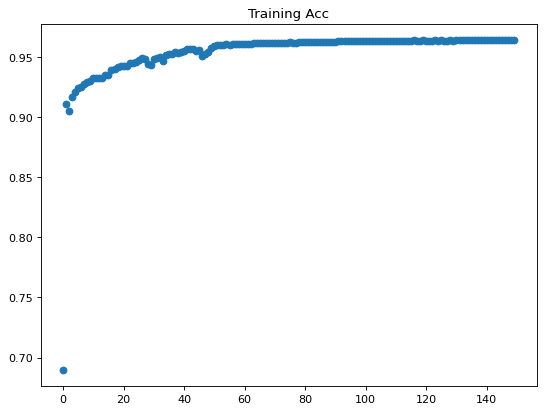

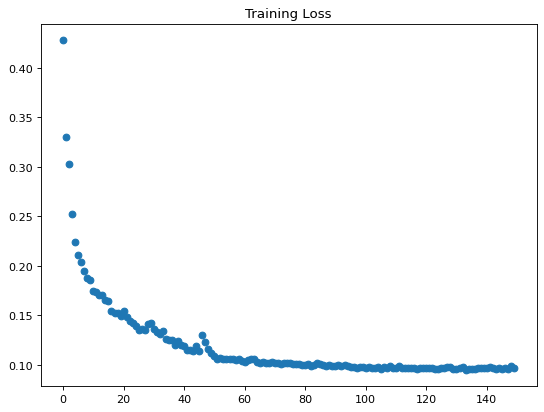

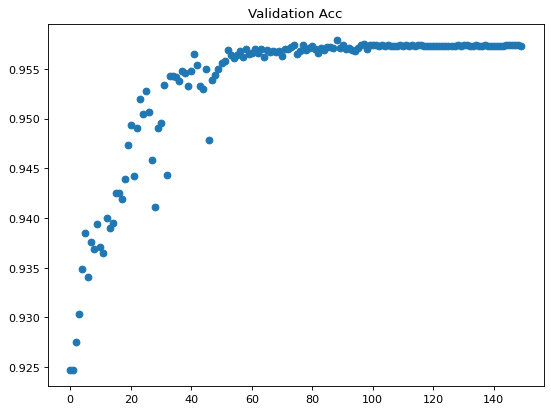

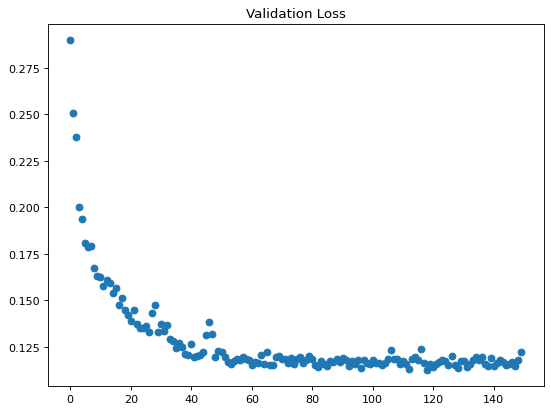

In [ ]:
plt.figure(num=None, figsize=(8,6), dpi=80)
plt.scatter(list(range(len(tr_acc))), tr_acc)
plt.title("Training Acc")
plt.figure(num=None, figsize=(8,6), dpi=80)
plt.scatter(list(range(len(tr_loss))), tr_loss)
plt.title("Training Loss")


plt.figure(num=None, figsize=(8,6), dpi=80)
plt.scatter(list(range(len(val_acc))), val_acc)
plt.title("Validation Acc")
plt.figure(num=None, figsize=(8,6), dpi=80)
plt.scatter(list(range(len(val_loss))), val_loss)
plt.title("Validation Loss")

results generated from train dataset


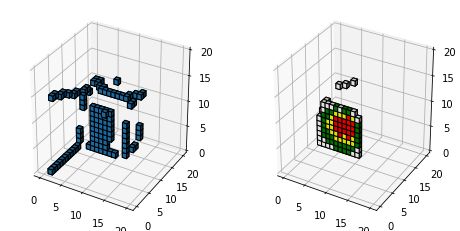

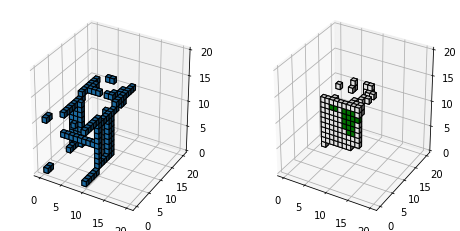

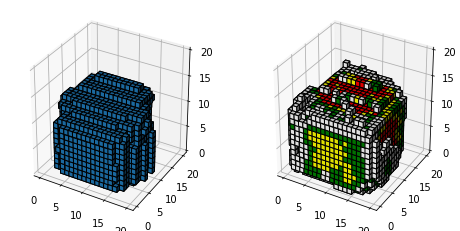

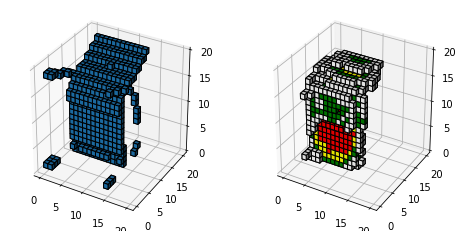

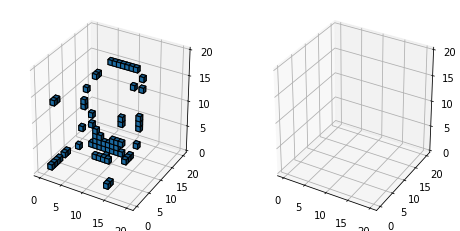

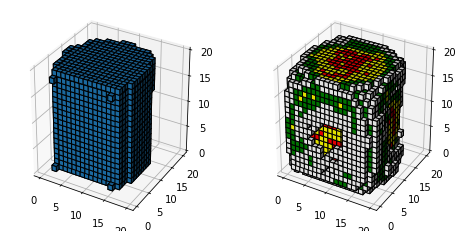

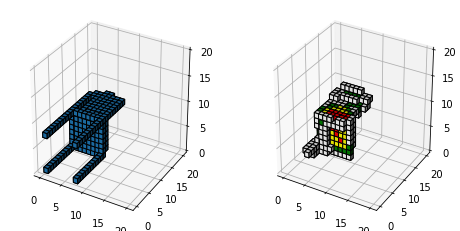

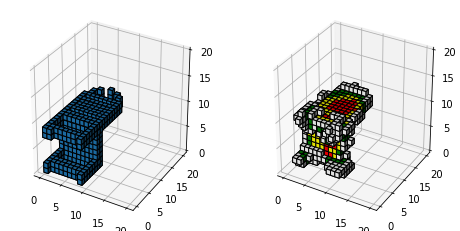

accuracy: 0.9645519480519481
results generated from val dataset


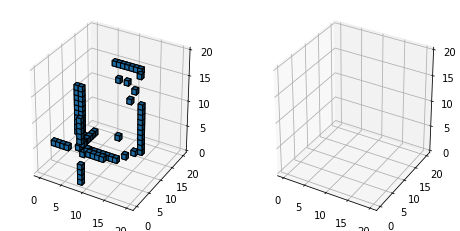

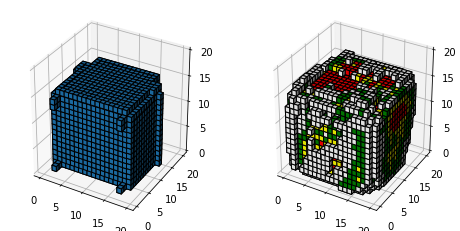

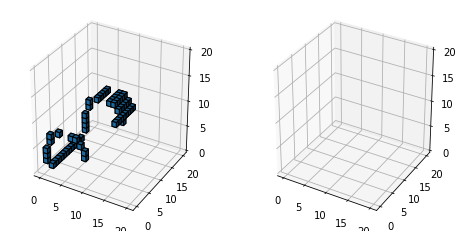

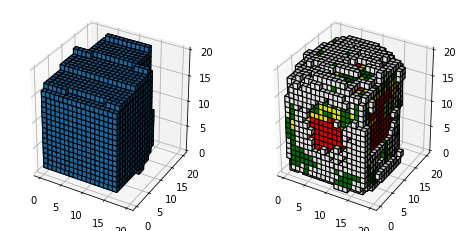

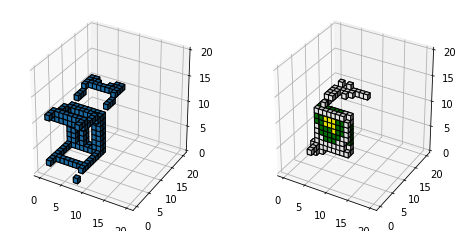

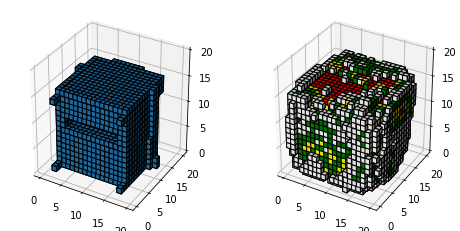

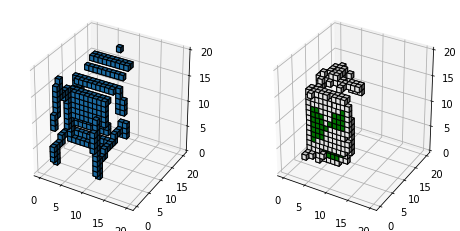

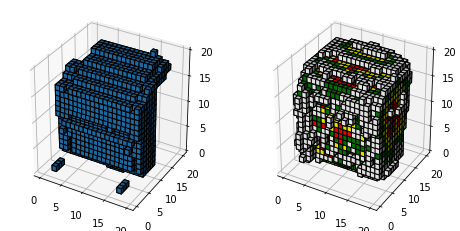

accuracy: 0.9590344827586207


In [ ]:
print('results generated from train dataset')
test_autoencoder(voxel_dataloader['train'], device)

print('results generated from val dataset')
test_autoencoder(voxel_dataloader['val'], device)

In [ ]:
def save_autoencoder_to_google_drive(encoder=None, decoder=None, reconst=None):
  if encoder == None:
      encoder = torch.load('./result/encoder.pt')
  if decoder == None:
      decoder = torch.load('./result/decoder.pt')
  if reconst == None:
      reconst = torch.load('./result/reconst.pt')

  torch.save(encoder, 'drive/My Drive/EECS 504/Models/encoder.pt')
  torch.save(decoder, 'drive/My Drive/EECS 504/Models/decoder.pt')
  torch.save(reconst, 'drive/My Drive/EECS 504/Models/reconst.pt')

def load_autoencoder_from_google_drive(path=None):
  if path == None:
    path = 'drive/My Drive/EECS 504/Models/'
  
  encoder = torch.load(path + 'encoder.pt')
  decoder = torch.load(path + 'decoder.pt')
  reconst = torch.load(path + 'reconst.pt')

  return encoder, decoder, reconst

def save_imagenet_to_google_drive(imagenet=None):
  if imagenet == None:
      imagenet = torch.load('./result/imagenet.pt')

  torch.save(encoder, 'drive/My Drive/EECS 504/Models/imagenet.pt')

def load_imagenet_from_google_drive(path=None):
  if path == None:
    path = 'drive/My Drive/EECS 504/Models/'
  return torch.load(path + 'imagenet.pt')


In [ ]:
save_autoencoder_to_google_drive()

In [ ]:
class Alexnet(nn.Module):
    def __init__(self):
        super(Alexnet, self).__init__()

        self.alexnet = torch.hub.load('pytorch/vision:v0.5.0', 'alexnet', pretrained=True)
        self.fc64 = nn.Linear(1000, 64)

    def forward(self, x):
        x = self.fc64(self.alexnet(x))
        return x

In [ ]:
def train_imagenet(dataloader, device, encoder, imagenet, optimizer, num_epochs=10):
    criterion = nn.MSELoss()
    #optimizer = torch.optim.SGD(imagenet.parameters(),lr=1e-1)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
    
    encoder.eval()
    tr_loss_his = []
    val_loss_his = []

    best_loss = 100

    for epoch in range(num_epochs):
        # print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        # print('-' * 10)
        for phase in ['train', 'val']:
            running_loss = 0.0

            if phase == 'train':
                imagenet.train()
            
            else:
                imagenet.eval()  # Set model to eval mode
        
            tqdm_loop = tqdm(dataloader[phase], ncols=120, ascii=True, position=0, leave=True)
            for index, (images, voxels) in enumerate(tqdm_loop):
                voxels = voxels[:, np.newaxis, :, :, :].type(dtype=torch.float32).to(device)
                voxels_scale = voxels * 255
                images = images.to(device)
                #images_scale = images * 255
                with torch.no_grad():
                  embedding = encoder(voxels_scale)

                outputs = imagenet(images)
                loss = criterion(outputs, embedding / 255)

                if phase == 'train':
                  optimizer.zero_grad()
                  loss.backward()
                  optimizer.step()
                
                # print('embedding -----------------')
                # print(embedding)
                # print('outputs -----------------')
                # print(outputs)
                running_loss += loss.item()
            
            epoch_loss = running_loss / len(tqdm_loop)
            print()
            print('Epoch {} {} Loss: {:.4f}'.format(epoch, phase, epoch_loss))
            
            if phase == 'train':
                scheduler.step()
                tr_loss_his.append(epoch_loss)
            else:
                val_loss_his.append(epoch_loss)

            if phase == "val" and epoch_loss < best_loss:
                best_loss = epoch_loss
                # save the model
                torch.save(imagenet, './result/imagenet.pt')

    return tr_loss_his, val_loss_his

def test_model(dataloader, device, encoder=None, decoder=None, reconst=None, imagenet=None):
    if encoder == None:
        encoder = torch.load('./result/encoder.pt')
    if decoder == None:
        decoder = torch.load('./result/decoder.pt')
    if reconst == None:
        reconst = torch.load('./result/reconst.pt')
    if imagenet == None:
        imagenet = torch.load('./result/imagenet.pt')

    encoder.eval()
    decoder.eval()
    reconst.eval()
    imagenet.eval()

    with torch.no_grad():
        #tqdm_loop = tqdm(dataloader, ascii=True)
        for index, (image, voxels) in enumerate(dataloader): 
            if index == 0:
                image = image.to(device)
                voxels = voxels[:, np.newaxis, :, :, :].type(dtype=torch.float32).to(device)

                output_img = decoder(reconst(imagenet(image) * 255)).cpu()
                # output_img[output_img >= 0.5] = 1
                # output_img[output_img < 0.5] = 0

                output_voxel = decoder(reconst(encoder(voxels * 255))).cpu()
                # output_voxel[output_voxel >= 0.5] = 1
                # output_voxel[output_voxel < 0.5] = 0

                print('original voxel | reconstructed voxel | predicted voxel')
                for i in range (5):
                    plot_voxels_3_color(voxels[i].squeeze(), output_voxel[i].squeeze(), output_img[i].squeeze())
        
            return


In [ ]:
alex_net = Alexnet()
print(alex_net.parameters)
freeze_parms = [
  'alexnet.features.0.weight',
  'alexnet.features.0.bias',
  'alexnet.features.3.weight',
  'alexnet.features.3.bias',
  'alexnet.features.6.weight',
  'alexnet.features.6.bias'
]
for name, p in alex_net.named_parameters():
  print(name)
  if name in freeze_parms:
    print('freezing')
    p.requires_grad = False

#optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, img_net.parameters()),lr=1e-1)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0


<bound method Module.parameters of Alexnet(
  (alexnet): AlexNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
    (classifier): Sequential(
      (0): Dr

In [ ]:
datapath = 'drive/My Drive/EECS 504/ProjectData/'
use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
print(f'using device: {device}')

img_dset = ImageVoxelDset(datapath + 'Rendered_Imgs', datapath + 'Voxel', ImgTransform=ToTensor())

used_size = int(0.2 * len(img_dset))
unused_size = len(img_dset) - used_size
used_dset, unused_dset = torch.utils.data.random_split(img_dset, [used_size, unused_size])

train_size = int(0.8 * len(used_dset))
val_size = len(used_dset) - train_size
train_dset, val_dset = torch.utils.data.random_split(used_dset, [train_size, val_size])

print(f"train size: {train_size}")
print(f"val size: {val_size}")

voxel_img_dataloader = {}
voxel_img_dataloader['train'] = DataLoader(train_dset, batch_size=32, shuffle=True, num_workers=4)
voxel_img_dataloader['val'] = DataLoader(val_dset, batch_size=32, shuffle=True, num_workers=4)

#voxel_img_loader = DataLoader(voxel_img_dataloader['train'], batch_size=10, shuffle=True)

encoder, decoder, reconst = load_autoencoder_from_google_drive()
encoder = encoder.to(device)
img_net = img_net.to(device)
#img_net = ImageNet().to(device)
#encoder = torch.load('./result/encoder.pt').to(device)
optimizer = torch.optim.Adam(img_net.parameters(), lr=1e-4)
#optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, img_net.parameters()),lr=1e-4)
#train_loss_his, val_loss_his = train_imagenet(voxel_img_dataloader, device, encoder, img_net, optimizer, num_epochs=25)

using device: cuda:0
train size: 3328
val size: 833


Text(0.5, 1.0, 'Validation Loss')

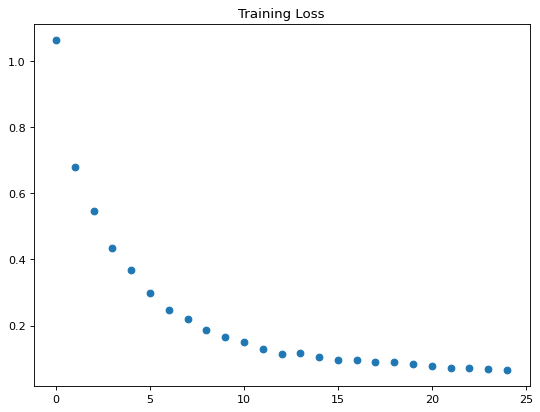

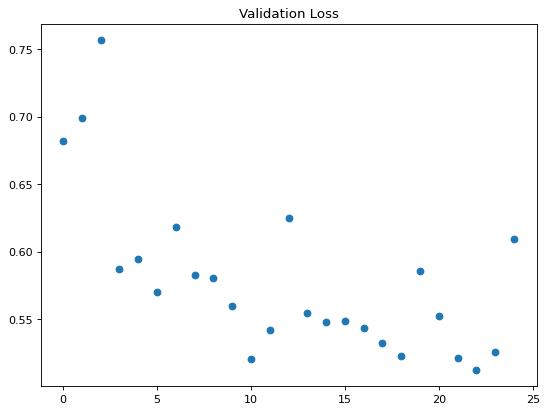

In [ ]:
plt.figure(num=None, figsize=(8,6), dpi=80)
plt.scatter(list(range(len(train_loss_his))), train_loss_his)
plt.title("Training Loss")

plt.figure(num=None, figsize=(8,6), dpi=80)
plt.scatter(list(range(len(val_loss_his))), val_loss_his)
plt.title("Validation Loss")

In [ ]:
def plot_image_voxels_3_color (img: np.ndarray, v2: np.ndarray):
  fig = plt.figure(figsize=(10,5), constrained_layout=True)
  ax = fig.add_subplot(1, 2, 1)

  ax.imshow(img)

  ax = fig.add_subplot(1, 2, 2, projection='3d')
  colors = np.zeros(v2.shape + (3,))
  high = (v2 > 0.8)
  mid = (v2 > 0.6) & (v2 < 0.8)
  low = (v2 > 0.4) & (v2 < 0.6)
  unsure = (v2 > 0.2) & (v2 < 0.4)

  colors = np.empty(v2.shape, dtype=object)
  colors[high] = 'red'
  colors[mid] = 'yellow'
  colors[low] = 'green'
  colors[unsure] = 'white'

  voxel = high | mid | low | unsure

  ax.voxels(voxel, facecolors=colors, edgecolor="k")

  plt.show()

def test_model_with_img(dataloader, device, encoder=None, decoder=None, reconst=None, imagenet=None):
    if encoder == None:
        encoder = torch.load('./result/encoder.pt')
    if decoder == None:
        decoder = torch.load('./result/decoder.pt')
    if reconst == None:
        reconst = torch.load('./result/reconst.pt')
    if imagenet == None:
        imagenet = torch.load('./result/imagenet.pt')

    encoder.eval()
    decoder.eval()
    reconst.eval()
    imagenet.eval()

    with torch.no_grad():
        #tqdm_loop = tqdm(dataloader, ascii=True)
        for index, (image, voxels) in enumerate(dataloader): 
            if index == 0:
                image = image.to(device)
                voxels = voxels[:, np.newaxis, :, :, :].type(dtype=torch.float32).to(device)

                output_img = decoder(reconst(imagenet(image) * 255)).permute(0,1,2,4,3).cpu()
                # output_img[output_img >= 0.5] = 1
                # output_img[output_img < 0.5] = 0

                # output_voxel = decoder(reconst(encoder(voxels * 255))).cpu()
                # output_voxel[output_voxel >= 0.5] = 1
                # output_voxel[output_voxel < 0.5] = 0
                image = image.permute(0,2,3,1).cpu()
                print('original voxel | reconstructed voxel | predicted voxel')
                for i in range (5):
                    plot_image_voxels_3_color(image[i], output_img[i].squeeze())
                    #plot_voxels_3_color(voxels[i].squeeze(), output_voxel[i].squeeze(), output_img[i].squeeze())
        
            return

val set
original voxel | reconstructed voxel | predicted voxel


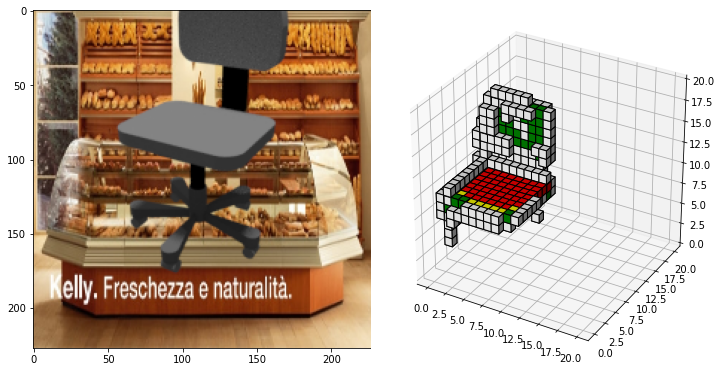

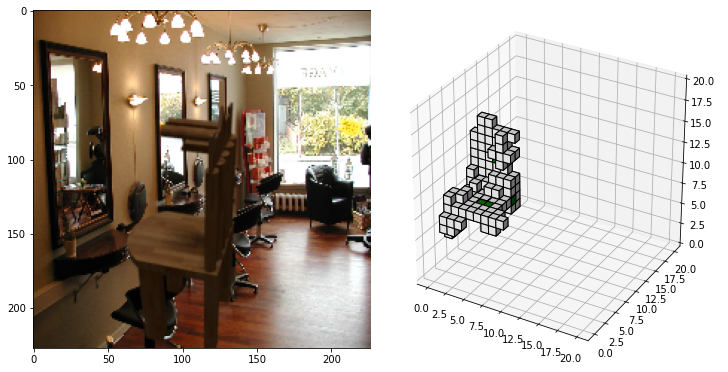

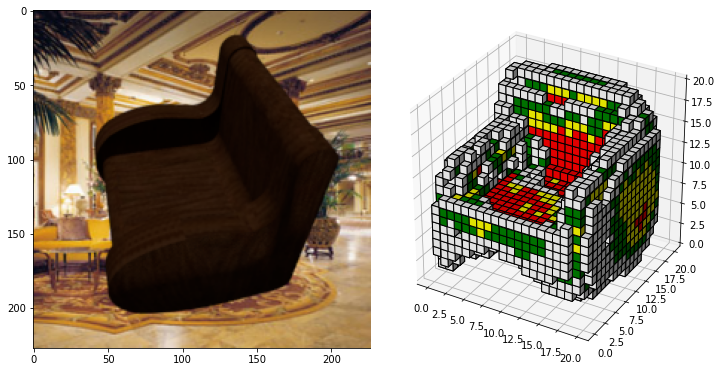

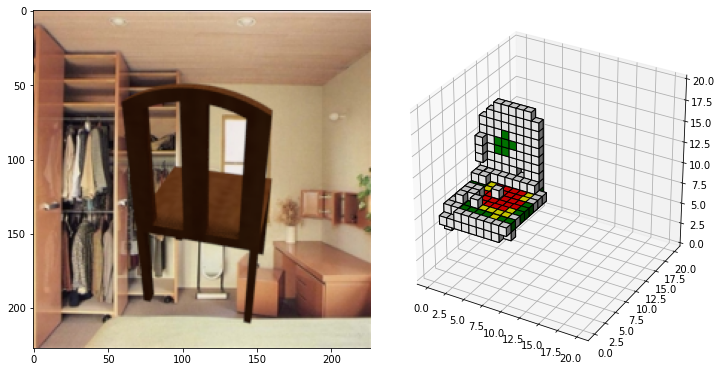

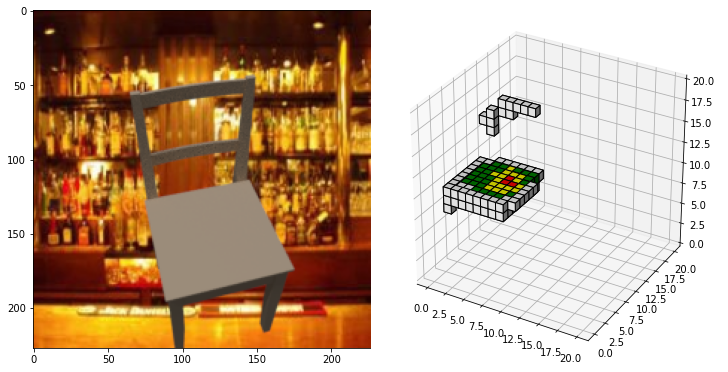

In [ ]:
encoder, decoder, reconst = load_autoencoder_from_google_drive('drive/My Drive/EECS 504/eecs504_project/trained_model/')
img_net = load_imagenet_from_google_drive('drive/My Drive/EECS 504/eecs504_project/trained_model/')
encoder = encoder.to(device)
decoder = decoder.to(device)
reconst = reconst.to(device)
img_net = img_net.to(device)
#print(encoder, decoder, reconst)
#print('train set')
#test_model_with_img(voxel_img_dataloader['train'], device, encoder, decoder, reconst, img_net)
print('val set')
test_model_with_img(voxel_img_dataloader['val'], device, encoder, decoder, reconst, img_net)

In [ ]:
def train_imagenet(dataloader, device, encoder, reconst, decoder, imagenet, optimizer, num_epochs=10):
    criterion = nn.MSELoss()
    #optimizer = torch.optim.SGD(imagenet.parameters(),lr=1e-1)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
    
    encoder.eval()
    tr_loss_his = []
    val_loss_his = []

    best_loss = 100

    for epoch in range(num_epochs):
        # print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        # print('-' * 10)
        for phase in ['train', 'val']:
            running_loss = 0.0

            if phase == 'train':
                imagenet.train()
            
            else:
                imagenet.eval()  # Set model to eval mode
        
            tqdm_loop = tqdm(dataloader[phase], ncols=120, ascii=True, position=0, leave=True)
            for index, (images, voxels) in enumerate(tqdm_loop):
                voxels = voxels[:, np.newaxis, :, :, :].type(dtype=torch.float32).to(device)
                voxels_scale = voxels * 255
                images = images.to(device)
                #images_scale = images * 255
                with torch.no_grad():
                  embedding = encoder(voxels_scale)

                outputs = imagenet(images)
                loss = criterion(outputs, embedding / 255)

                if phase == 'train':
                  optimizer.zero_grad()
                  loss.backward()
                  optimizer.step()
                
                # print('embedding -----------------')
                # print(embedding)
                # print('outputs -----------------')
                # print(outputs)
                running_loss += loss.item()
            
            epoch_loss = running_loss / len(tqdm_loop)
            print()
            print('Epoch {} {} Loss: {:.4f}'.format(epoch, phase, epoch_loss))
            
            if phase == 'train':
                scheduler.step()
                tr_loss_his.append(epoch_loss)
            else:
                val_loss_his.append(epoch_loss)

            if phase == "val" and epoch_loss < best_loss:
                best_loss = epoch_loss
                # save the model
                torch.save(imagenet, './result/imagenet.pt')

    return tr_loss_his, val_loss_his
